In [18]:
#Question 2b
import numpy as np
import matplotlib.pyplot as plt
from time import perf_counter
from scipy.optimize import brentq

In [11]:
#CDF F(x)
def F(x):
    return 1.0 - (x + 1.0) * np.exp(-x)

In [12]:
#root function F(x) - u
def g(x, u):
    return 1.0 - (x + 1.0) * np.exp(-x) - u

In [13]:
#solve F(x) = u for x >= 0 using bracketing + brentq.
#brents method is fastest and can be more resistant to crashing
def inverse_cdf_numeric(u, x_hi_start=10.0):
    lo = 0.0
    hi = x_hi_start
    while F(hi) < u: #while loop ensures 'hi' is high enough
        hi *= 2.0
    return brentq(g, lo, hi, args=(u,), maxiter=100)

In [14]:
#main experiment 
N = 10**6
rng = np.random.default_rng(777)
U = rng.uniform(0.0, 1.0, size=N)

start = perf_counter() #timer
X = np.empty_like(U)

for i, u in enumerate(U):
    X[i] = inverse_cdf_numeric(u)

elapsed = perf_counter() - start
print(f"Runtime for N={N}: {elapsed:.3f} seconds")

# sanity checks
print("min(X) =", X.min())  # should be >= 0
print("mean(X) ≈", X.mean())  # should be close to 2 for Gamma(2,1)

Runtime for N=1000000: 42.253 seconds
min(X) = 0.001172434596795526
mean(X) ≈ 2.001498177604434


Question 2c
Optimal value of c is 4/e, with the acceptance rate being e/4, or approzimately 0.6796.

In [15]:
#f(x) = x e^{-x}, g(x) = (1/2) e^{-x/2}, c* = 4/e
c_star = 4 / np.e

#sample in batches using NumPy to make calculations faster
def rejection_sample_gamma21(N, batch_size=200_000, seed=777):
    rng = np.random.default_rng(seed)
    accepted = []
    n_acc = 0

    start = perf_counter()

    while n_acc < N:
        # 1) Propose Y ~ g, where g is Exp(rate=1/2) => scale = 2
        Y = rng.exponential(scale=2.0, size=batch_size)

        # 2) Uniforms for accept/reject
        U = rng.uniform(0.0, 1.0, size=batch_size)

        # 3) Compute acceptance probability: f(Y) / (c g(Y))
        # ratio f/g = 2Y exp(-Y/2)
        # so f/(c g) = (2Y exp(-Y/2)) / (4/e) = (e/2) Y exp(-Y/2)
        A = (np.e / 2.0) * Y * np.exp(-Y / 2.0)

        # Accept if U <= A
        keep = Y[U <= A]

        accepted.append(keep)
        n_acc += keep.size

    X = np.concatenate(accepted)[:N]
    runtime = perf_counter() - start
    return X, runtime

N = 10**6
X, runtime = rejection_sample_gamma21(N)

print(f"c* = {c_star:.6f}")
print(f"Acceptance rate (theory) = {np.e/4:.6f}")
print(f"Runtime for {N} accepted samples: {runtime:.3f} seconds")
print("Sanity checks: min =", X.min(), "mean ≈", X.mean())  # mean should be ~2


c* = 1.471518
Acceptance rate (theory) = 0.679570
Runtime for 1000000 accepted samples: 0.145 seconds
Sanity checks: min = 0.001191313804633452 mean ≈ 1.9997362672479786


In [20]:
#Question 2d

N = 10**6
rng = np.random.default_rng(777)

start = perf_counter()

E1 = rng.exponential(scale=1.0, size=N)
E2 = rng.exponential(scale=1.0, size=N)
X = E1 + E2

elapsed = perf_counter() - start

print(f"Runtime for N={N}: {elapsed:.6f} seconds")
print("Sanity checks: min =", X.min(), "mean ≈", X.mean())


Runtime for N=1000000: 0.072716 seconds
Sanity checks: min = 0.0014519069502925458 mean ≈ 2.000741872546045


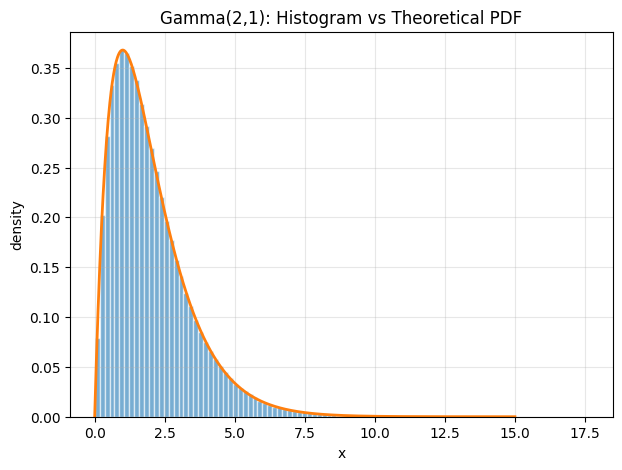

In [21]:
#Question 2e

#theoretical PDF (gamma(2,1))
x_grid = np.linspace(0, 15, 1000)
pdf = x_grid * np.exp(-x_grid)   

#plot
plt.figure(figsize=(7, 5))

#histogram normalized to area 1
plt.hist(X, bins=100, density=True, alpha=0.6, edgecolor='white')

#theoretical curve
plt.plot(x_grid, pdf, linewidth=2)

plt.xlabel("x")
plt.ylabel("density")
plt.title("Gamma(2,1): Histogram vs Theoretical PDF")
plt.grid(alpha=0.3)
plt.savefig("pbm2.png", dpi=300, bbox_inches="tight")
plt.show()
